# Colab E(iv): TensorFlow High-Level API (Sequential + `model.fit`)

**Maximum Abstraction — `keras.Sequential`, `model.compile`, `model.fit`**

---

### Approach
- `keras.Sequential` to stack layers
- `model.compile()` to set optimizer, loss, metrics
- `model.fit()` for built-in training loop
- `model.evaluate()` for testing
- Callbacks for early stopping and learning rate scheduling

## Cell 1: Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

tf.random.set_seed(42)
np.random.seed(42)
print(f'TensorFlow: {tf.__version__}')

TensorFlow: 2.19.0


## Cell 2: Generate Data

In [2]:
num_samples = 2000
x1 = np.random.uniform(-2, 2, num_samples)
x2 = np.random.uniform(-2, 2, num_samples)
x3 = np.random.uniform(-2, 2, num_samples)
y_true = np.sin(x1) * x2**2 + np.cos(x3) * x1 + 0.5 * x3 * x2

X_np = np.column_stack([x1, x2, x3]).astype(np.float32)
Y_np = y_true.reshape(-1, 1).astype(np.float32)
X_mean, X_std = X_np.mean(0), X_np.std(0)
Y_mean, Y_std = Y_np.mean(), Y_np.std()
X_norm = ((X_np - X_mean) / X_std).astype(np.float32)
Y_norm = ((Y_np - Y_mean) / Y_std).astype(np.float32)

# Train/Val/Test split
n_train = int(0.7 * num_samples)
n_val = int(0.15 * num_samples)
X_train, Y_train = X_norm[:n_train], Y_norm[:n_train]
X_val, Y_val = X_norm[n_train:n_train+n_val], Y_norm[n_train:n_train+n_val]
X_test, Y_test = X_norm[n_train+n_val:], Y_norm[n_train+n_val:]

print(f'Train: {n_train}, Val: {n_val}, Test: {num_samples-n_train-n_val}')

Train: 1400, Val: 300, Test: 300


## Cell 3: 4D Visualization

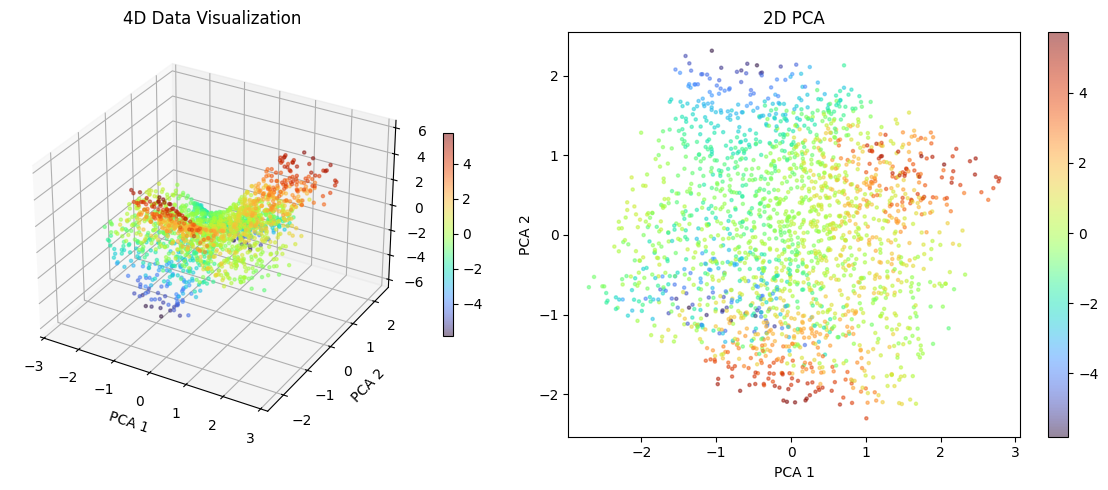

In [3]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, projection='3d')
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], Y_np.flatten(), c=Y_np.flatten(), cmap='turbo', s=5, alpha=0.5)
ax.set_xlabel('PCA 1'); ax.set_ylabel('PCA 2'); ax.set_zlabel('y')
ax.set_title('4D Data Visualization')
plt.colorbar(sc, ax=ax, shrink=0.5)
ax2 = fig.add_subplot(122)
sc2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=Y_np.flatten(), cmap='turbo', s=5, alpha=0.5)
ax2.set_xlabel('PCA 1'); ax2.set_ylabel('PCA 2'); ax2.set_title('2D PCA')
plt.colorbar(sc2, ax=ax2)
plt.tight_layout(); plt.show()

## Cell 4: Build Sequential Model

The simplest Keras API — just stack layers in a list.

In [4]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', kernel_initializer='he_normal', input_shape=(3,), name='hidden_1'),
    layers.Dense(32, activation='relu', kernel_initializer='he_normal', name='hidden_2'),
    layers.Dense(16, activation='relu', kernel_initializer='he_normal', name='hidden_3'),
    layers.Dense(1, name='output')
], name='sequential_regression_dnn')

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_regression_dnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,881 (11.25 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)

## Cell 5: Compile Model

In [5]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)
print('Model compiled with Adam optimizer, MSE loss, and MAE metric.')

Model compiled with Adam optimizer, MSE loss, and MAE metric.


## Cell 6: Define Callbacks

In [6]:
# Early stopping to prevent overfitting
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True, verbose=1
)

# Reduce learning rate on plateau
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1
)

print('Callbacks: EarlyStopping (patience=20), ReduceLROnPlateau (factor=0.5, patience=10)')

Callbacks: EarlyStopping (patience=20), ReduceLROnPlateau (factor=0.5, patience=10)


## Cell 7: Train with model.fit()

In [7]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

print(f'\nTraining stopped at epoch {len(history.history["loss"])}')

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.0790 - mae: 1.1101 - val_loss: 0.5862 - val_mae: 0.5558 - learning_rate: 0.0010
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4335 - mae: 0.4810 - val_loss: 0.3582 - val_mae: 0.4239 - learning_rate: 0.0010
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2695 - mae: 0.3772 - val_loss: 0.2158 - val_mae: 0.3221 - learning_rate: 0.0010
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1501 - mae: 0.2759 - val_loss: 0.1076 - val_mae: 0.2362 - learning_rate: 0.0010
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0874 - mae: 0.2176 - val_loss: 0.0731 - val_mae: 0.1999 - learning_rate: 0.0010
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0632 - mae: 0.1886 - val_loss: 0.0560 - val_mae: 0.1756 - learning_rate: 0.0010
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0488 - mae: 0.1672 - val_loss: 0.0463 - val_mae: 0.1615 - learning_rate: 0.0010
Epoch 8/100


## Cell 8: Plot Training History

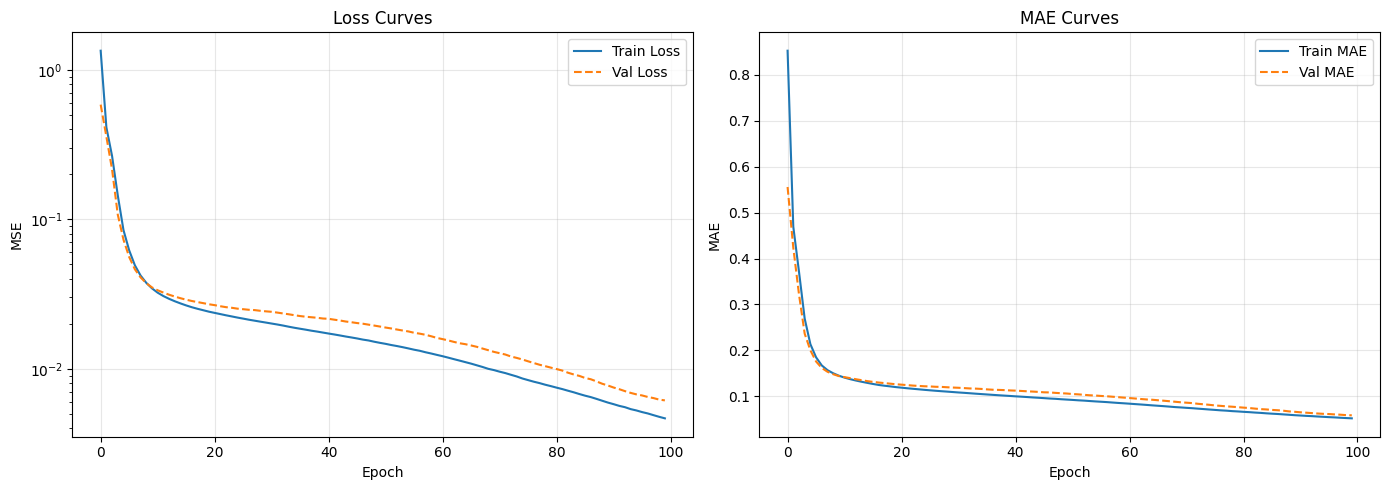

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(history.history['loss'], label='Train Loss', lw=1.5)
ax1.plot(history.history['val_loss'], label='Val Loss', lw=1.5, ls='--')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('MSE'); ax1.set_title('Loss Curves')
ax1.legend(); ax1.grid(True, alpha=0.3); ax1.set_yscale('log')

# MAE
ax2.plot(history.history['mae'], label='Train MAE', lw=1.5)
ax2.plot(history.history['val_mae'], label='Val MAE', lw=1.5, ls='--')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('MAE'); ax2.set_title('MAE Curves')
ax2.legend(); ax2.grid(True, alpha=0.3)

plt.tight_layout(); plt.show()

## Cell 9: Evaluate on Test Set

In [9]:
test_results = model.evaluate(X_test, Y_test, verbose=0)
print(f'Test Loss (MSE): {test_results[0]:.6f}')
print(f'Test MAE: {test_results[1]:.6f}')

Test Loss (MSE): 0.006245
Test MAE: 0.062581


## Cell 10: Final Results

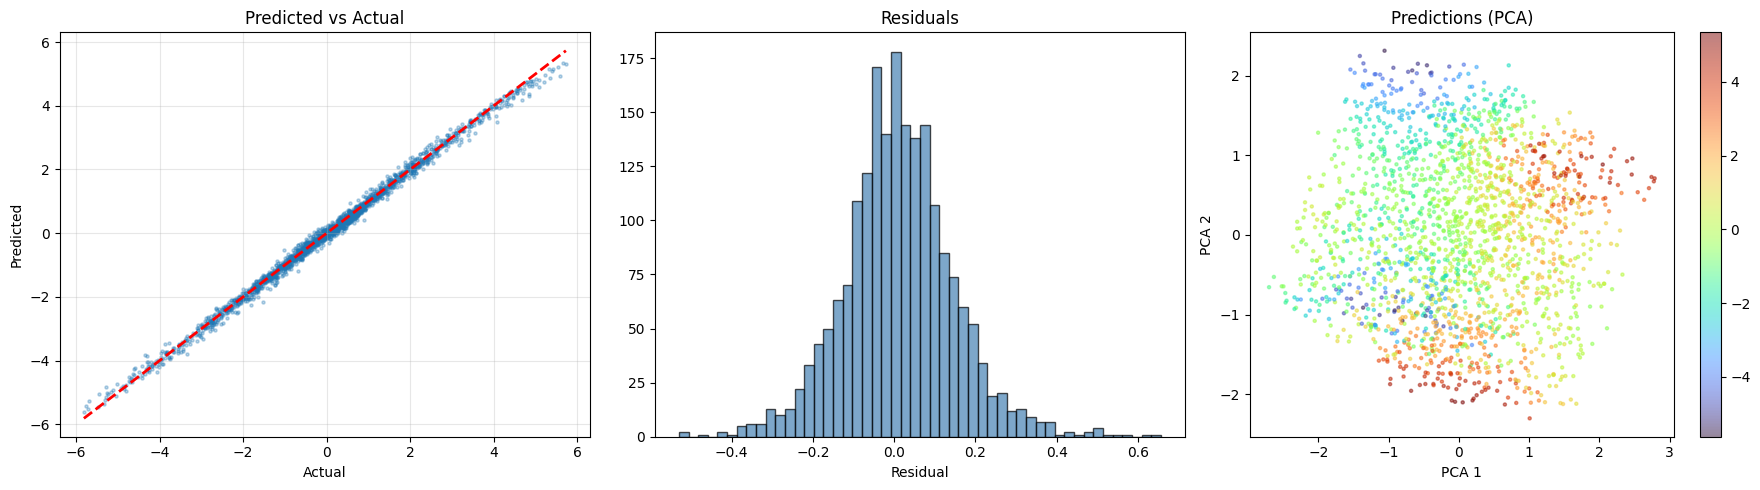

R-squared: 0.9952 | MAE: 0.1036


In [10]:
Y_pred = model.predict(X_norm, verbose=0)
Y_pred_d = Y_pred * Y_std + Y_mean
res = Y_np.flatten() - Y_pred_d.flatten()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].scatter(Y_np.flatten(), Y_pred_d.flatten(), alpha=0.3, s=5)
axes[0].plot([Y_np.min(), Y_np.max()], [Y_np.min(), Y_np.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual'); axes[0].set_ylabel('Predicted')
axes[0].set_title('Predicted vs Actual'); axes[0].grid(True, alpha=0.3)

axes[1].hist(res, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Residual'); axes[1].set_title('Residuals')

sc = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=Y_pred_d.flatten(), cmap='turbo', s=5, alpha=0.5)
axes[2].set_xlabel('PCA 1'); axes[2].set_ylabel('PCA 2')
axes[2].set_title('Predictions (PCA)')
plt.colorbar(sc, ax=axes[2])
plt.tight_layout(); plt.show()

r2 = 1 - np.sum(res**2) / np.sum((Y_np.flatten() - Y_np.mean())**2)
print(f'R-squared: {r2:.4f} | MAE: {np.mean(np.abs(res)):.4f}')

## Cell 11: Summary

In [11]:
print('='*60)
print('Colab E(iv): TF High-Level Sequential API — Complete!')
print('='*60)
print('Uses: keras.Sequential, model.compile, model.fit, model.evaluate')
print('Callbacks: EarlyStopping, ReduceLROnPlateau')
print('This is the HIGHEST level of abstraction in TensorFlow/Keras')
print(f'R-squared: {r2:.4f}')
print('='*60)

Colab E(iv): TF High-Level Sequential API — Complete!
Uses: keras.Sequential, model.compile, model.fit, model.evaluate
Callbacks: EarlyStopping, ReduceLROnPlateau
This is the HIGHEST level of abstraction in TensorFlow/Keras
R-squared: 0.9952
